In [1]:
import yfinance as yf
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
ms = yf.download('MSFT',
            start="2012-01-01",
            end="2021-12-31",
            progress=False)
df = ms[["Adj Close", "Open", "Close", "High", "Low"]].round(3)
df.head(10)

,Adj Close,Open,Close,High,Low
Date,,,,,
2012-01-03,21.278,26.55,26.77,26.96,26.39
2012-01-04,21.779,26.82,27.40,27.47,26.78
2012-01-05,22.001,27.38,27.68,27.73,27.29
2012-01-06,22.343,27.53,28.11,28.19,27.53
2012-01-09,22.049,28.05,27.74,28.10,27.72
2012-01-10,22.129,27.93,27.84,28.15,27.75
2012-01-11,22.033,27.43,27.72,27.98,27.37
2012-01-12,22.256,27.87,28.00,28.02,27.65
2012-01-13,22.454,27.93,28.25,28.25,27.79


In [3]:
def ts_data(df, X_steps, y_steps):
  train_df = df[:"2020"].Close.values.reshape(-1, 1)
  test_df = df["2021":].Close.values.reshape(-1, 1)

  sc = MinMaxScaler(feature_range=(0, 1))
  train_df_scaled = sc.fit_transform(train_df)

  X_train = []
  y_train = []
  for i in range(X_steps, len(train_df_scaled)-y_steps+1):
    X_train.append(train_df_scaled[i-X_steps:i, 0])
    y_train.append(train_df_scaled[i:i+y_steps, 0])
  X_train = np.array(X_train)
  y_train = np.array(y_train)

  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

  X = df.Close.values
  X = X[len(X)-len(test_df)-X_steps:]
  X = X.reshape(-1, 1)
  X = sc.transform(X)

  X_test = []
  y_test = []
  for i in range(X_steps, len(test_df)+X_steps-y_steps+1):
    X_test.append(X[i-X_steps:i, 0])
    y_test.append(X[i:i+y_steps, 0])

  X_test = np.array(X_test)
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
  y_test = np.array(y_test)

  return X_train, y_train, X_test, y_test, sc

In [4]:
X_train, y_train, X_test, y_test, sc = ts_data(df, 6, 2)

# Gluonts

In [5]:
!pip install gluonts[mxnet]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [7]:
import gluonts
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [8]:
train_data = ListDataset(
    [{"start":df.index[0], "target":df.Close[:"2020"]}],
    freq="D"
)

<Axes: >

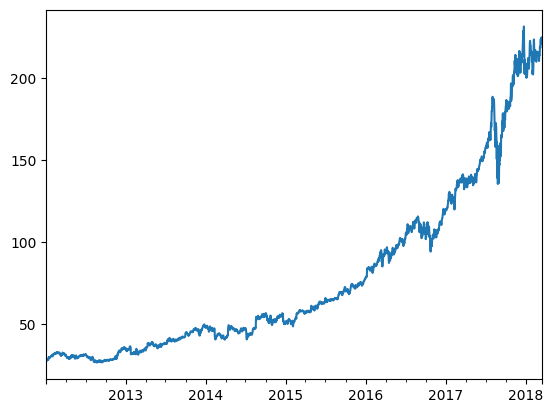

In [9]:
train_listData = next(iter(train_data))
train_series = to_pandas(train_listData)
train_series.plot()

In [10]:
test_data = ListDataset(
    [{"start":df.index[0], "target":df.Close}],
    freq="D"
)

<Axes: >

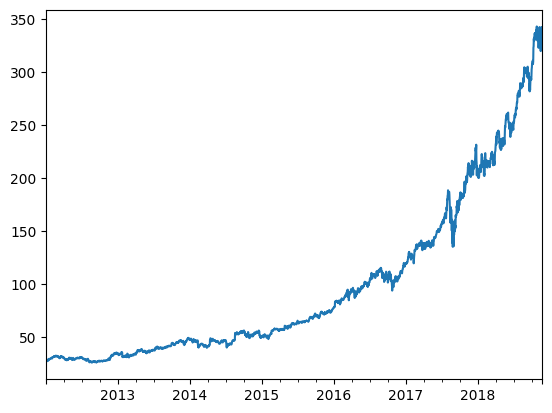

In [11]:
test_listData = next(iter(test_data))
test_series = to_pandas(test_listData)
test_series.plot()

In [12]:
from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging,SelectNBestMean

In [13]:
callbacks = [
      LearningRateReduction(objective="min",
                            patience=10,
                            base_lr=1e-3,
                            decay_factor=0.5),
      ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]

In [14]:
deepAR_model = DeepAREstimator(
    freq="D",
    prediction_length=5,
    context_length=10,
    num_layers=4,
    num_cells=100,
    dropout_rate=0.05,
    trainer=Trainer(epochs=10, callbacks=callbacks)
)

In [15]:
deepAR_model_predictator = deepAR_model.train(train_data)

100%|██████████| 50/50 [00:08<00:00,  6.22it/s, epoch=10/10, avg_epoch_loss=1.8]


In [16]:
from gluonts.evaluation import make_evaluation_predictions

In [31]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=deepAR_model_predictator,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [32]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [33]:
ts_entry = tss[0]

In [34]:
forecast_entry = forecasts[0]

In [35]:
forecast_entry

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[326.7276 , 334.86618, 354.30115, 333.94595, 326.5357 ],
       [337.1726 , 323.49628, 301.15784, 332.3505 , 344.84186],
       [309.31198, 327.55914, 337.5437 , 331.76816, 340.1939 ],
       [315.73648, 333.73364, 327.02124, 329.93903, 332.14874],
       [336.71536, 328.98022, 338.3613 , 345.6109 , 341.2558 ],
       [332.11   , 343.08237, 331.99384, 332.30103, 341.83957],
       [323.52448, 329.32324, 334.82553, 318.74988, 367.32748],
       [331.65808, 320.78125, 310.468  , 339.00415, 314.34772],
       [326.3753 , 334.32068, 341.90686, 333.0624 , 333.3054 ],
       [327.6451 , 339.281  , 328.54623, 339.52304, 328.04294],
       [324.53986, 331.5454 , 334.938  , 340.53177, 322.14413],
       [329.94403, 342.44876, 324.93936, 334.5991 , 315.4475 ],
       [338.37933, 334.61533, 324.05612, 334.65826, 324.44333],
       [310.1059 , 338.61688, 331.16678, 331.92984, 326.04712],
       [337.35553, 321.78696, 367

In [36]:
forecast_entry.samples.shape

(100, 5)

TypeError: ignored

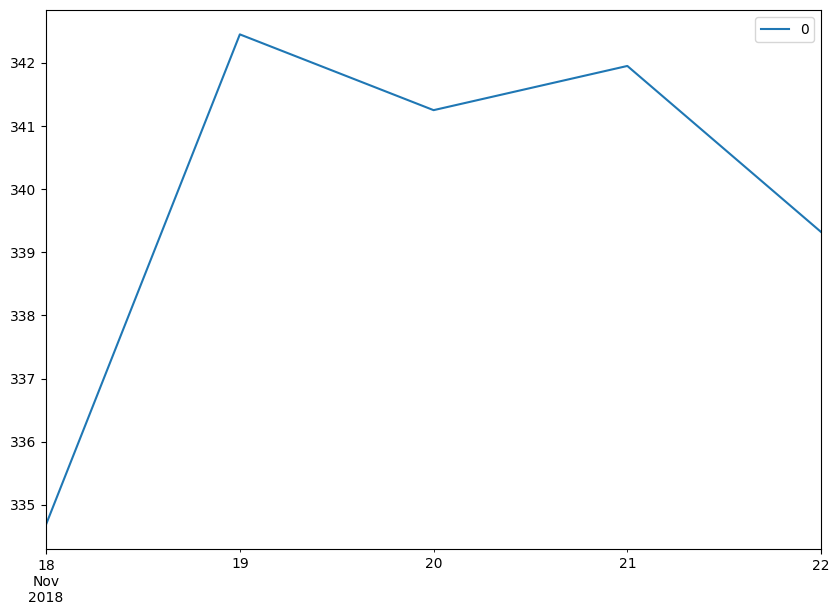

In [25]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 5
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")

plot_prob_forecasts(ts_entry, forecast_entry)